In [ ]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random


In [ ]:
# device 설정 (GPU가 있으면 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("사용하는 device:", device)

# MNIST 데이터셋 준비
# 데이터 전처리를 위해 ToTensor 변환을 적용
transform = transforms.Compose([transforms.ToTensor()])

# 학습용 MNIST 데이터셋 다운로드 및 로드
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)


사용하는 device: cuda


In [ ]:
### VAE (Variational Autoencoder) 모델 정의 ###
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        """
        VAE 모델 초기화 함수.
        매개변수:
            latent_dim : 잠재 공간(latent space)의 차원 (기본값: 2)
        """
        super(VAE, self).__init__()
        # 인코더 정의: 입력 이미지를 400 차원의 중간 표현으로 변환
        self.fc1 = nn.Linear(28 * 28, 400)
        # 잠재 변수의 평균과 로그 분산을 출력하는 두 개의 Fully Connected 레이어
        self.fc21 = nn.Linear(400, latent_dim)  # 잠재 변수의 평균 (mean)
        self.fc22 = nn.Linear(400, latent_dim)  # 잠재 변수의 로그 분산 (log variance)

        # 디코더 정의: 잠재 변수에서 400 차원의 중간 표현을 복원한 후 원래 이미지 크기로 복원
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        """
        인코딩 함수: 입력 x를 인코더를 통해 숨은 표현(hidden representation)으로 변환하고,
        잠재 변수의 평균과 로그 분산을 출력합니다.
        """
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """
        재파라미터화 트릭 (Reparameterization Trick)
        잠재 변수 z를 평균과 로그 분산으로부터 샘플링합니다.
        이를 통해 역전파 과정에서 미분이 가능하도록 합니다.
        """
        std = torch.exp(0.5 * logvar)  # 표준편차 계산 logvar는 log(sigma^2) -->  std = exp((1/2) * log(sigma^2)) = sigma
        eps = torch.randn_like(std)    # 평균 0, 표준편차 1인 노이즈 생성
        return mu + eps * std

    def decode(self, z):
        """
        디코딩 함수: 잠재 변수 z를 받아 원래 이미지 차원으로 복원합니다.
        """
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))  # 출력값을 0~1 사이로 제한

    def forward(self, x):
        """
        순전파 함수: 인코더 -> 재파라미터화 -> 디코더 순서로 진행합니다.
        반환값은 재구성된 이미지, 잠재 변수의 평균, 로그 분산입니다.
        """
        mu, logvar = self.encode(x.view(-1, 28 * 28))  # 이미지를 벡터로 펼침
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
### 손실 함수 정의 ###
# VAE의 손실 함수는 재구성 손실(BCE)과 KL 발산(KLD) 손실의 합으로 구성됩니다.
# beta 값은 KL 손실의 가중치를 조절합니다.
beta = 1.0
def loss_function(recon_x, x, mu, logvar):
    """
    손실 함수:
        - BCE (Binary Cross-Entropy): 입력과 재구성 이미지 간의 차이를 측정.
        - KLD (Kullback-Leibler Divergence): 잠재 공간 분포와 정규 분포 간의 차이를 측정.
    최종 손실 = BCE + beta * KLD
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD


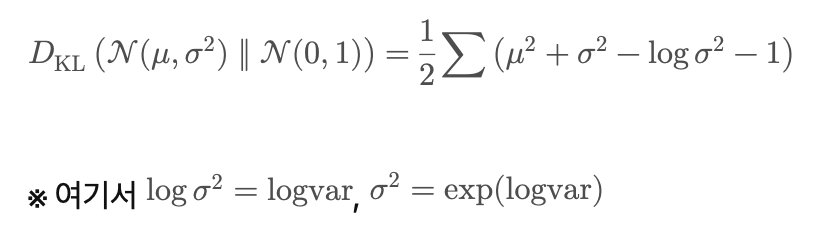

In [ ]:
### 모델 학습: 2D 잠재 공간으로 학습 ###
# 잠재 공간 차원 설정 (여기서는 2차원)
latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

print("2D 잠재 공간으로 학습 시작...")
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)  # 데이터 GPU로 이동 (가능한 경우)
        optimizer.zero_grad()   # 기울기 초기화
        recon_batch, mu, logvar = model(data)  # 순전파 진행
        loss = loss_function(recon_batch, data, mu, logvar)  # 손실 계산
        loss.backward()         # 역전파
        train_loss += loss.item()
        optimizer.step()        # 가중치 업데이트

    # 에포크마다 평균 손실 출력
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset)}')


2D 잠재 공간으로 학습 시작...
Epoch 1, Loss: 204.55721881510416
Epoch 2, Loss: 173.9412814453125
Epoch 3, Loss: 167.48007067057293
Epoch 4, Loss: 164.53532711588542
Epoch 5, Loss: 162.6805030924479
Epoch 6, Loss: 161.26730026041668
Epoch 7, Loss: 160.1373533203125
Epoch 8, Loss: 159.1844308268229
Epoch 9, Loss: 158.31536878255207
Epoch 10, Loss: 157.60732872721354
Epoch 11, Loss: 156.96097154947915
Epoch 12, Loss: 156.38579884440105
Epoch 13, Loss: 155.87486025390626
Epoch 14, Loss: 155.36295696614584
Epoch 15, Loss: 154.946158203125
Epoch 16, Loss: 154.5249918457031
Epoch 17, Loss: 154.19527164713543
Epoch 18, Loss: 153.8206158203125
Epoch 19, Loss: 153.45861469726563
Epoch 20, Loss: 153.2122920735677
Epoch 21, Loss: 152.85908999023437
Epoch 22, Loss: 152.59824833984376
Epoch 23, Loss: 152.39199371744792
Epoch 24, Loss: 152.06107709960938
Epoch 25, Loss: 151.89782797851564
Epoch 26, Loss: 151.65799529622396
Epoch 27, Loss: 151.3781138997396
Epoch 28, Loss: 151.1940602701823
Epoch 29, Loss: 151.

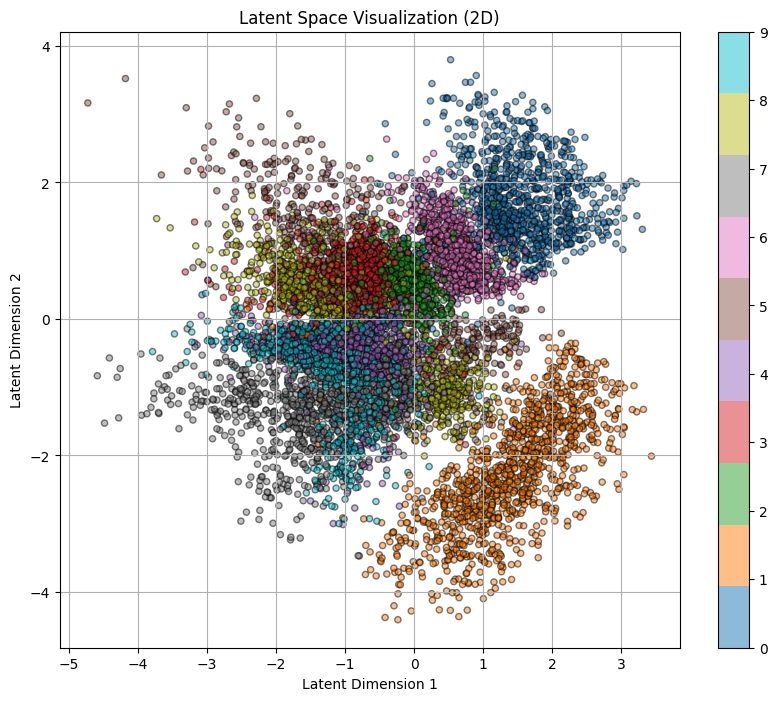

In [ ]:
### 잠재 공간 시각화 (2D) 및 테스트 데이터셋 처리 ###
model.eval()  # 평가 모드로 전환
all_z = []    # 모든 잠재 변수 저장 리스트
all_labels = []  # 해당 이미지의 레이블 저장 리스트

# 테스트 데이터셋 다운로드 및 로드 (학습 데이터와는 별개)
with torch.no_grad():
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=64, shuffle=False)

    # 테스트 데이터셋에 대해 인코딩 및 잠재 변수 샘플링 진행
    for data, labels in testloader:
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 28 * 28))
        z = model.reparameterize(mu, logvar)
        z = z.cpu().numpy()

        all_z.append(z)
        all_labels.append(labels)

    all_z = np.concatenate(all_z)
    all_labels = np.concatenate(all_labels)

    # 2D 잠재 공간에 대해 산점도(scatter plot) 시각화
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', alpha=0.5, edgecolors='k', s=20)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization (2D)')
    plt.grid(True)
    plt.show()


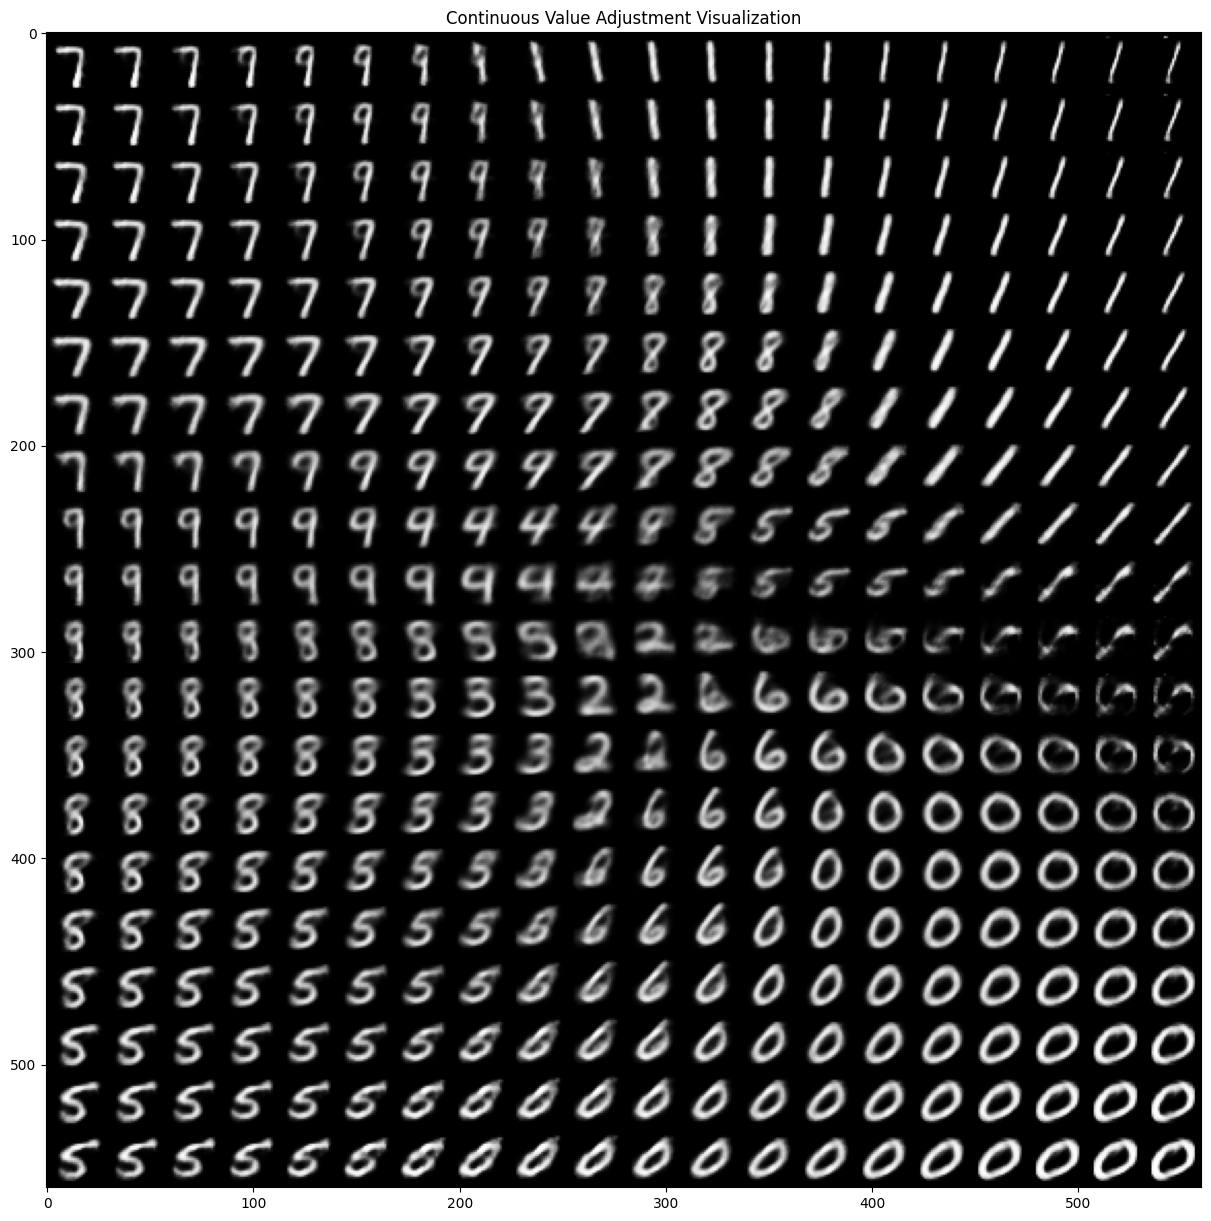

In [ ]:
### 잠재 공간을 활용한 새로운 데이터 생성 (연속적 값 조정)
# 잠재 공간에서 샘플을 생성하여 디코더로 복원한 후, 그 결과를 그리드 형태로 시각화합니다.
with torch.no_grad():
    grid_x = np.linspace(-3, 3, 20)  # x축 범위 및 샘플링 개수 설정
    grid_y = np.linspace(-3, 3, 20)  # y축 범위 및 샘플링 개수 설정
    figure = np.zeros((28 * 20, 28 * 20))  # 전체 이미지를 저장할 빈 배열 생성
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # 현재 좌표 (xi, yi)를 잠재 변수로 변환 후 디코딩
            z_sample = torch.Tensor([[xi, yi]]).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded.view(28, 28).cpu().numpy()
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='gray')
    plt.title('Continuous Value Adjustment Visualization')
    plt.show()


In [ ]:
### 잠재 공간 차원 확장: 128D로 재학습 ###
# 잠재 공간의 차원을 128로 확장하여 학습하면 재구성 품질이 개선될 수 있습니다.
latent_dim = 128
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100

print("128D 잠재 공간으로 학습 시작...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in trainloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(trainloader.dataset)}')


128D 잠재 공간으로 학습 시작...
Epoch 1, Loss: 195.2216832356771
Epoch 2, Loss: 143.7747874674479
Epoch 3, Loss: 130.98689983723958
Epoch 4, Loss: 123.063218359375
Epoch 5, Loss: 117.807070703125
Epoch 6, Loss: 114.47711215820313
Epoch 7, Loss: 112.12387027994792
Epoch 8, Loss: 110.54538473307292
Epoch 9, Loss: 109.35741735026042
Epoch 10, Loss: 108.36710467122396
Epoch 11, Loss: 107.66331513671875
Epoch 12, Loss: 107.08734469401041
Epoch 13, Loss: 106.61035455729167
Epoch 14, Loss: 106.19964912109376
Epoch 15, Loss: 105.87928818359374
Epoch 16, Loss: 105.55672592773438
Epoch 17, Loss: 105.3530421875
Epoch 18, Loss: 105.12999840494791
Epoch 19, Loss: 104.88890559895833
Epoch 20, Loss: 104.69561069335937
Epoch 21, Loss: 104.54886328125
Epoch 22, Loss: 104.40258372395833
Epoch 23, Loss: 104.26582555338541
Epoch 24, Loss: 104.1139794921875
Epoch 25, Loss: 104.00063019205729
Epoch 26, Loss: 103.85263294270834
Epoch 27, Loss: 103.78644949544271
Epoch 28, Loss: 103.66400797526042
Epoch 29, Loss: 103.6

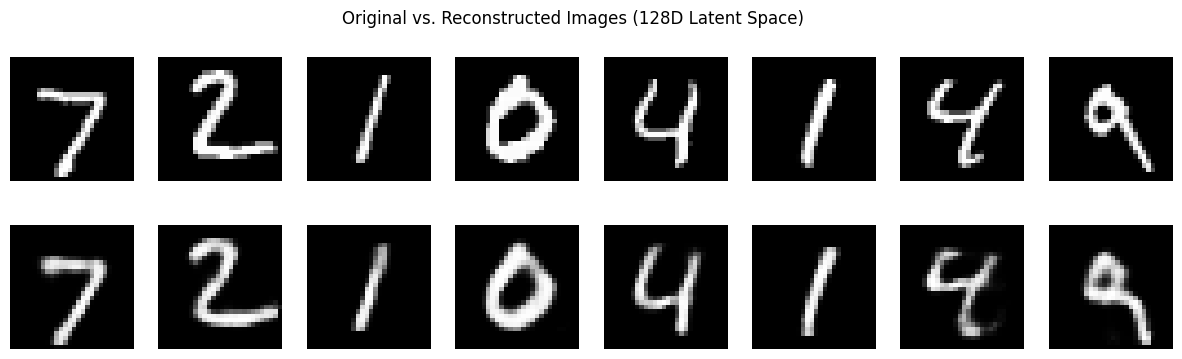

In [ ]:
### 128D 잠재 공간 재구성 결과 시각화 ###
model.eval()
with torch.no_grad():
    # 테스트 데이터셋에서 일부 데이터를 선택하여 재구성 결과 확인
    data, _ = next(iter(testloader))
    data = data.to(device)
    recon, _, _ = model(data)
    recon = recon.view(-1, 1, 28, 28).cpu().numpy()

    # 원본 이미지와 재구성 이미지를 나란히 비교하여 시각화
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        # 첫 번째 행: 원본 이미지
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # 두 번째 행: 재구성된 이미지
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Original vs. Reconstructed Images (128D Latent Space)")
    plt.show()


### 참고

#### KL 발산 : N(u, sigma^2), N(0, 1)

두 정규분포 $q(z) = {N}(\mu, \sigma^2)$와 $p(z) = {N}(0,1)$의 KL 발산을 계산해보면:

1. **정의부터 시작합니다.**  
   일반적인 KL 발산의 정의는  
   $
   D_{\text{KL}}(q(z) \parallel p(z)) = \int q(z) \log \frac{q(z)}{p(z)} \, dz
   $  
   입니다.

2. **각 분포의 확률 밀도 함수를 대입합니다.**  
   - q(z)의 밀도:  
     $
     q(z) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(z-\mu)^2}{2\sigma^2}\right)
     $
   - p(z)의 밀도:  
     $
     p(z) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{z^2}{2}\right)
     $

3. **로그의 차이를 계산합니다.**  
   $
   \log \frac{q(z)}{p(z)} = \log\left(\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(z-\mu)^2}{2\sigma^2}\right) \Big/ \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{z^2}{2}\right)\right)
   $\
   여기서 로그를 분리하면,  
   $log \frac{q(z)}{p(z)} = -\frac{1}{2}\log(\sigma^2) -\frac{(z-\mu)^2}{2\sigma^2} + \frac{z^2}{2}
   $

4. **q(z)에 대해 기댓값을 취하는 적분을 수행하면,**  
   여러 표준적 통계량(예, $\mathbb{E}_{q}[z] = \mu, \mathbb{E}_{q}[z^2] = \mu^2+\sigma^2$)을 사용하여, 적분 결과가  
   $
   D_{\text{KL}}(q(z) \parallel p(z)) = \frac{1}{2}\left(\mu^2 + \sigma^2 - 1 - \log \sigma^2\right)
   $
   로 나오게 됩니다.

5. **다변량일 경우**  
   각 차원마다 위와 같은 계산을 진행하면, 최종 식은  
   $
   D_{\text{KL}}(q(z|x) \parallel p(z)) = \frac{1}{2} \sum_{i=1}^{d} \left( \mu_i^2 + \sigma_i^2 - 1 - \log \sigma_i^2 \right)
   $
   가 됩니다.
